In [1]:
from utils.binaries import *
from utils.plotting import *

peaks = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v42/peak.txt', usecols=range(3, 153))
charges = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v42/charge.txt', usecols=range(3, 603))

10:15:06 (   +9.9s) [INFO   ] -- import logging
10:15:06 (    +1ms) [INFO   ] -- import numpy as np
10:15:06 (    +5ms) [INFO   ] -- import uncertainties
10:15:06 (    +1ms) [INFO   ] -- import numpy as np
10:15:06 (    +5ms) [INFO   ] -- import uncertainties
10:15:06 (  +225ms) [INFO   ] -- import pandas as pd
10:15:06 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
10:15:06 (    +2ms) [INFO   ] -- import binaries.tools as tools
10:15:07 (  +283ms) [INFO   ] -- import matplotlib.pyplot as plt
10:15:07 (  +365ms) [INFO   ] -- import seaborn as so
10:15:07 (    +1ms) [INFO   ] -- import plotting.tools as plot
10:15:07 (    +7ms) [DEBUG  ] -- font size set to 9.5
10:15:07 (    +1ms) [DEBUG  ] -- label size set to 13.0
10:15:07 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
10:15:07 (    +0ms) [DEBUG  ] -- markersize set to 2.0
10:15:07 (    +1ms) [DEBUG  ] -- usetex set to False


In [2]:
peaks = np.split(peaks, len(peaks)/4)
charges = np.split(charges, len(charges)/4)

In [20]:
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from itertools import product
from utils import CONSTANTS

class SdHisto():
    def __init__(self, *, peak: list[np.ndarray]=None, charge: list[np.ndarray]=None) -> None:

        assert peak is None or len(peak) == 4, 'Missing a PMT?'
        assert charge is None or len(charge) == 4, 'Missing a PMT?'
        
        self.histos = {
            'peak' : peak,
            'charge' : charge
        }
        self.popts = {
            'peak': [[np.nan, np.nan] for _ in range(4)], 
            'charge': [[np.nan, np.nan] for _ in range(4)]
        }


    def fit(self, correlate: bool = True) -> dict:

        if self.histos['peak'] is not None: 
            self.popts['peak'] = self.get_peak('peak', correlate)
        if self.histos['charge'] is not None:
            self.popts['charge'] = self.get_peak('charge', correlate)

        return self.popts


    def get_peak(self, mode: str, correlate: bool) -> list[list[uncertainties.ufloat]]:

        peaks = []
        for i, counts in enumerate(self.histos[mode]):

            if i < 3: peaks.append(self.fit_wcd(counts[:(99 if mode=='peak' else 399)], correlate))
            else: peaks.append(self.fit_ssd(counts[:(99 if mode=='peak' else 399)], correlate))

        return peaks
    

    @staticmethod
    def fit_wcd(counts: np.ndarray, correlate: bool) -> list[uncertainties.ufloat]:

        try:
            match len(counts):
                case  99: 
                    increment = 5
                    bins = CONSTANTS.UUB_WCD_PEAK
                    initial_start = 99 - increment
                case 399: 
                    increment = 20
                    bins = CONSTANTS.UUB_WCD_CHARGE
                    initial_start = 399 - increment
                case _:
                    raise IndexError(f'received histogram with length {len(counts)}')

            old_peak, guess = np.argmax(counts[initial_start:]), 0
            while old_peak != guess:
                old_peak = guess
                initial_start -= increment
                guess = np.argmax(counts[initial_start:]) + initial_start

            start, stop = guess - increment, guess + increment
            x1, x2, y1, y2 = start, len(counts)-1, counts[stop], counts[len(counts)-1]
            background_slope = lambda x: (y2-y1)/(x2-x1)*(x-x1) + y1
    
            popts, pcov = curve_fit(SdHisto.parabola, bins[start:stop], 
                                    np.log(counts[start:stop]) - background_slope(np.arange(start, stop, 1)),
                                    bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                    maxfev=100000, p0=[-0.01, bins[guess], counts[guess]],
                                    nan_policy='omit')

            if correlate:
                popts = uncertainties.correlated_values(popts, pcov)
                # if len(counts) == 99 and popts[1].n < 100 or 300 < popts[1].n: raise ValueError(f"calculated {popts[1]:i} ADC for WCD peak")
                # if len(counts) == 399 and popts[1].n < 1000 or 2000 < popts[1].n: raise ValueError(f"calculated {popts[1]:i} ADC for WCD charge")
                if (r := popts[1].std_dev / popts[1].n) > 0.2: raise ValueError(f"large fit error for WCD: {r*100:.0f}%")

                return popts

        except ValueError as e:
            print(f'WCD SdHisto fit failed: {e}')
            return [uncertainties.ufloat(np.nan, np.nan) for _ in range(3)]


    @staticmethod
    def fit_ssd(counts: np.ndarray, correlate: bool) -> list[uncertainties.ufloat]:

        try:
            match len(counts):
                case  99: 
                    bins = CONSTANTS.UUB_SSD_PEAK
                    increment = 5
                    start = np.argmax(counts)

                    while not np.argmax(counts[start:]):
                        start += 1
                case 399: 
                    bins = CONSTANTS.UUB_SSD_CHARGE
                    increment = 20
                    order = 10

                    while len((dips := argrelextrema(counts[1:], np.less, order=order)[0])) > 1:
                        order += 1
                    start = dips[0] + 1

                case _:
                    raise IndexError(f'received histogram with length {len(counts)}')


            guess = start + np.argmax(counts[start:])
            start, stop = guess - increment, guess + increment

            popts, pcov = curve_fit(SdHisto.parabola, bins[start:stop], counts[start:stop],
                                    bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                    maxfev=100000, p0=[-0.01, bins[guess], counts[guess]],
                                    nan_policy='omit')

            if correlate:
                popts = uncertainties.correlated_values(popts, pcov)
                # if len(counts) == 99 and popts[1].n < 20 or 100 < popts[1].n: raise ValueError(f"calculated {popts[1]:i} ADC for SSD peak")
                # if len(counts) == 399 and popts[1].n < 20 or 100 < popts[1].n: raise ValueError(f"calculated {popts[1]:i} ADC for SSD charge")
                if (r := popts[1].std_dev / popts[1].n) > 0.2: raise ValueError(f"large fit error for SSD: {r*100:.0f}%")

                return popts
        
        except ValueError as e:
            print(f'SSD SdHisto fit failed: {e}')
            return [uncertainties.ufloat(np.nan, np.nan) for _ in range(4)]
    

    def plot(self) -> plt.Figure:
        
        if self.histos['peak'] is not None and self.histos['charge'] is not None:
            fig, (ax1, ax2) = plt.subplots(1, 2)
        else:
            fig, ax = plt.subplots()
            ax1 = ax2 = ax

        f = 4
        c = ['red', 'blue', 'mediumturquoise', 'k']
        l = ['WCD1', 'WCD2', 'WCD3', rf'SSD $\times$ {f}']
        
        if self.histos['peak'] is not None:
            ax1.set_xlabel('max. pulse height / ADC')
            for i, counts in enumerate(self.histos['peak']):
                factor = 1 if i<3 else f
                ax1.plot(self.get_bins('peak', i) * factor, counts, c=c[i], ls='-', label=l[i])
                ax1.axvline(self.popts['peak'][i][1].n * factor, lw=0.4, ls='--', c=c[i])
                err = self.popts['peak'][i][1].std_dev * np.array([-1, 1]) + self.popts['peak'][i][1].n
                ax1.axvspan(*(err * factor), color=c[i], alpha=0.1)

            ax1.set_xlim(0, 400)
            ax1.legend(title='Peak')

        if self.histos['charge'] is not None:
            ax2.set_xlabel('integral / ADC')
            for i, counts in enumerate(self.histos['charge']):
                factor = 1 if i<3 else f
                ax2.plot(self.get_bins('charge', i) * factor, counts, c=c[i], ls='-', label=l[i])
                ax2.axvline(self.popts['charge'][i][1].n * factor, lw=0.4, ls='--', c=c[i])
                err = self.popts['charge'][i][1].std_dev * np.array([-1, 1]) + self.popts['charge'][i][1].n
                ax2.axvspan(*(err * factor), color=c[i], alpha=0.1)
            
            ax2.set_xlim(0, 3200)
            ax2.legend(title='Charge')

        return fig
    

    @staticmethod
    def parabola(x, scale, mip, y0):
        return scale * (x-mip)**2 + y0


    @staticmethod
    def get_bins(mode: str, pmt: int) -> np.ndarray:

        if mode == 'peak' and pmt < 3:
            return CONSTANTS.UUB_WCD_PEAK
        elif mode == 'peak' and pmt == 3:
            return CONSTANTS.UUB_SSD_PEAK
        elif mode == 'charge' and pmt < 3:
            return CONSTANTS.UUB_WCD_CHARGE
        elif mode == 'charge' and pmt == 3:
            return CONSTANTS.UUB_SSD_CHARGE

WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 
WCD SdHisto fit failed: operands could not be broadcast together with shapes (0,) (10,) 


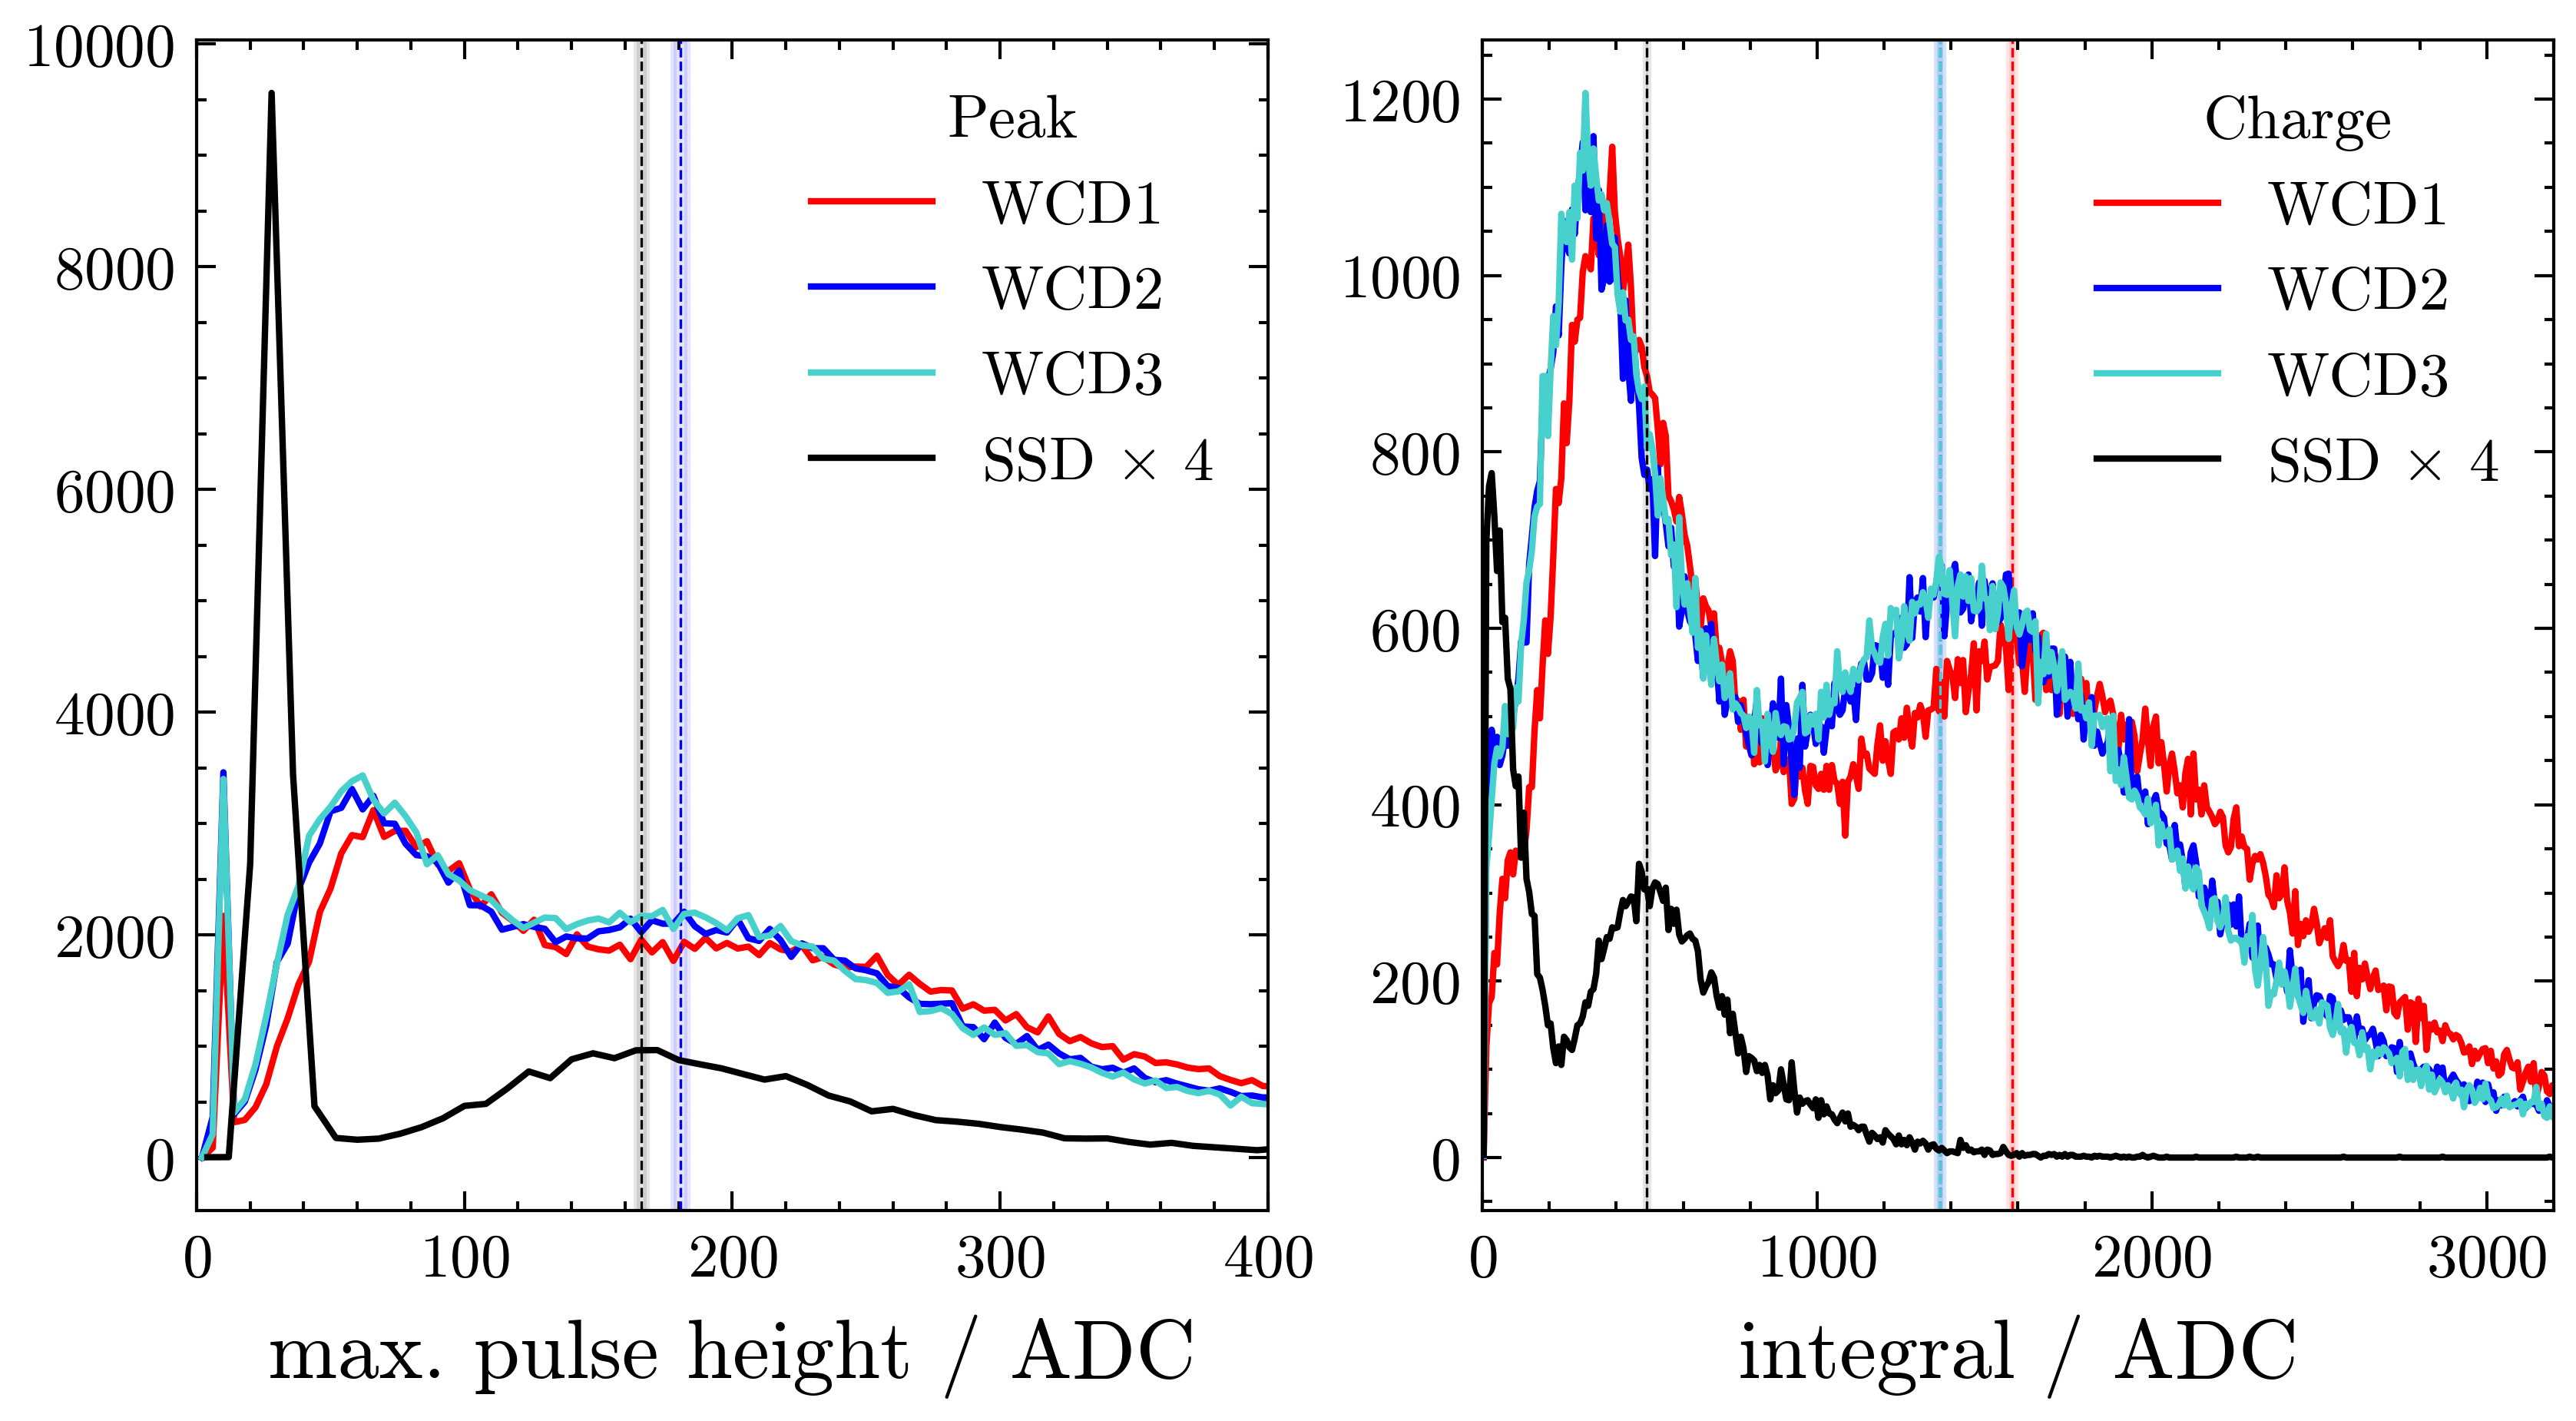

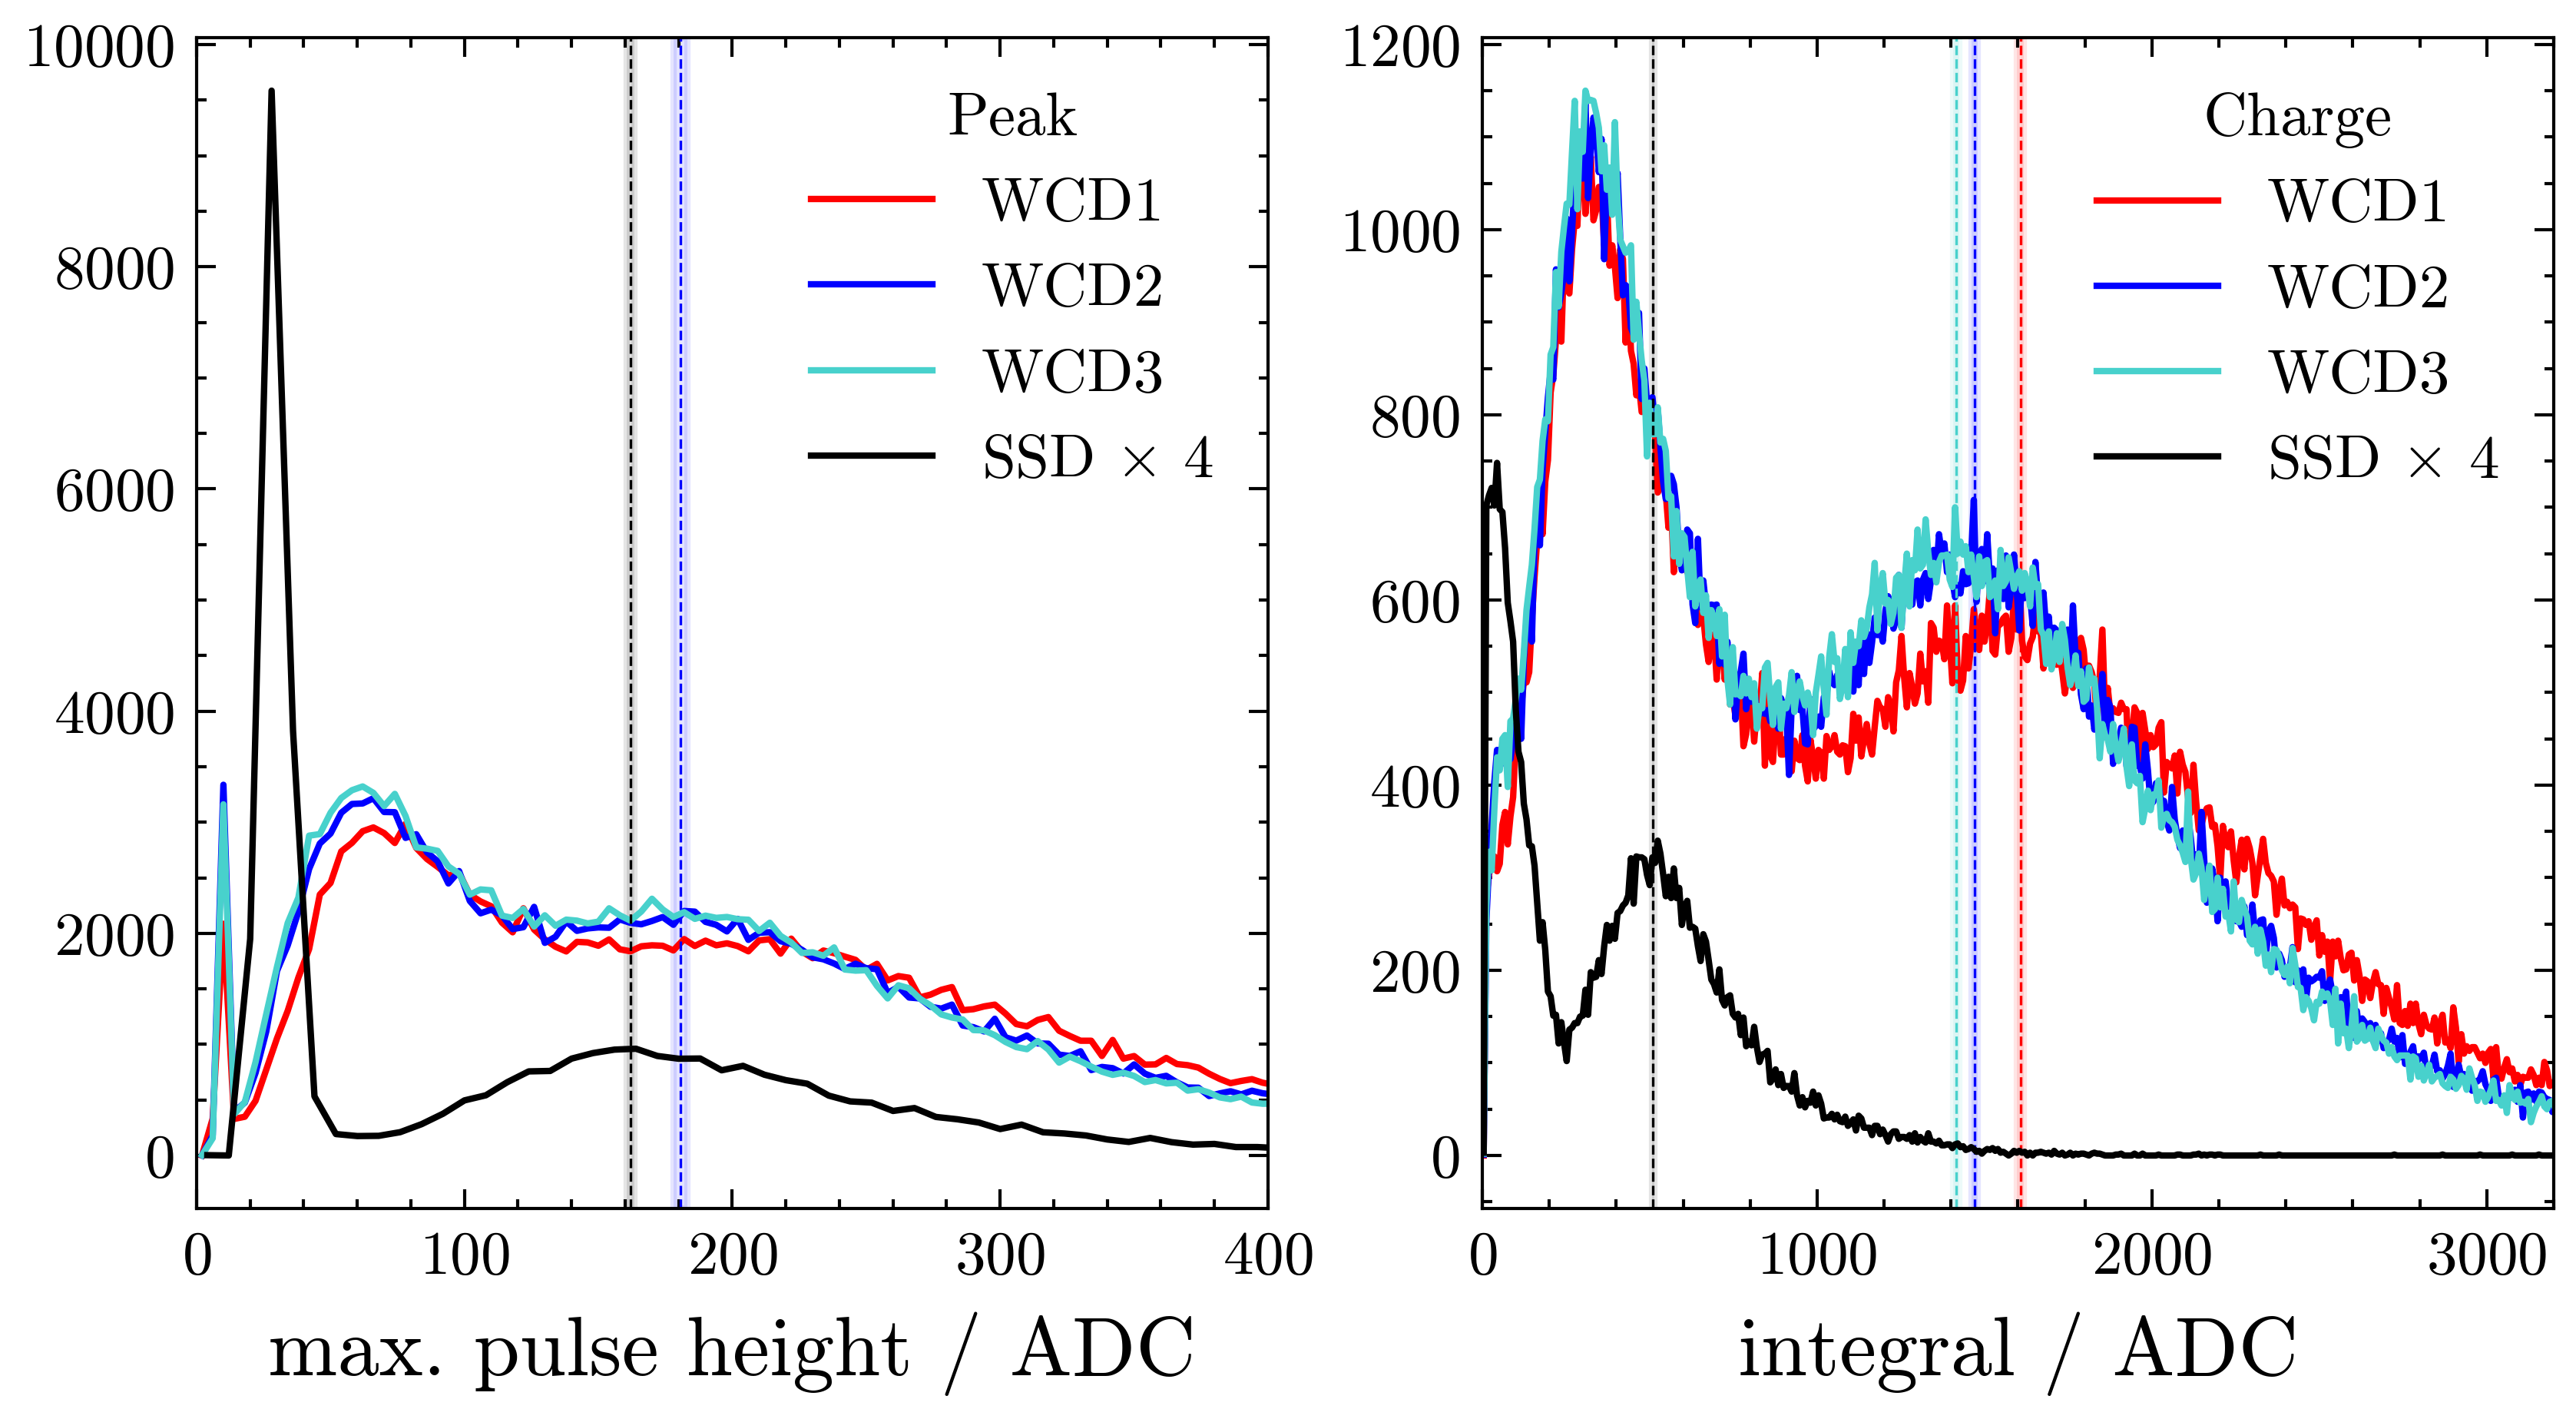

In [21]:
for i, (p, c) in enumerate(zip(peaks, charges)):
    histo = SdHisto(peak=p, charge=c)
    histo.fit()
    histo.plot()

    if i > 0: break

    # break

In [78]:
import pandas as pd

df = pd.read_csv(f'/cr/data01/filip/xy-calibration/results/outPositionsComb_12809.txt', sep=',', names=('time', 'x', 'y', 
                            'event_number', 'user_id', 'temp_led', 'temp_phd', 'temp_board', 'phd_signal', 
                            'FDeventSum'), comment='#', header=0)


df['r'] = np.sqrt(df['x']**2 + df['y']**2)
df['f'] = df['FDeventSum'] / df['FDeventSum'].max()


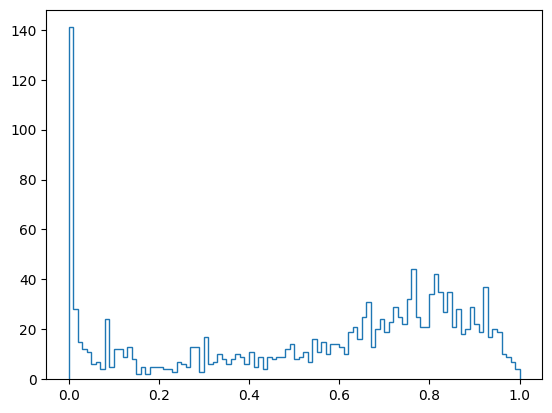

In [79]:
import matplotlib.pyplot as plt

_ = plt.hist(df['f'], histtype='step', bins=100)
# plt.xlim(0, 0.2)

In [80]:
import numpy as np

df['r'] = np.sqrt(df['x']**2 + df['y']**2)

df_select = df[(df['f'].between(0, 0.1)) & (df['r'] > 850)]

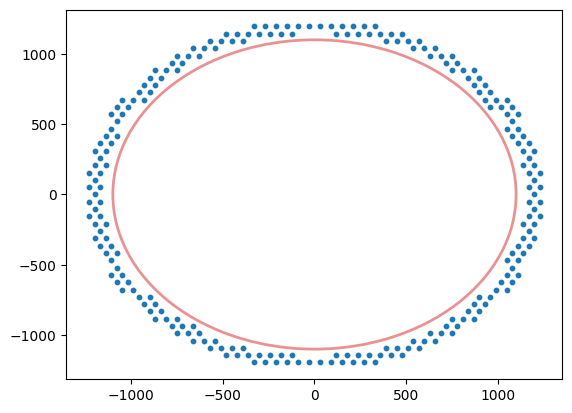

In [81]:
plt.scatter(df_select['x'], df_select['y'], s=10)
aperture = plt.Circle((0, 0), 1100, color='tab:red', fill=False, lw=2, zorder=0, alpha=0.5)

plt.gca().add_artist(aperture)

In [64]:
df_select['r']

Series([], Name: r, dtype: float64)